In [8]:
import sklearn as sk
import numpy as np
import pandas as pd
import time
from sklearn.cross_validation import KFold
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets
import theano.tensor as th
from scipy import misc
import copy
from numpy.random import uniform
from numpy.random import normal
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import os
import struct
import numpy as np
from sklearn.datasets import make_classification
from math import copysign

import matplotlib.pylab as plt
%matplotlib inline

# autoencoder + rmb

In [9]:
class rbm:
    def __init__(self, learning_rate, mu_moment, batch_size, num_epochs, hidden_count, mode):
        self.learning_rate = learning_rate
        self.mu_moment = mu_moment
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.hidden_count = hidden_count
        self.mode = mode
        
    def sigmoid(self, matrix):
        return 1. / (1. + np.exp(-matrix))
    
    def init_weights(self, vis_count):
        self.w_vh = np.random.normal(0, 0.1, (vis_count, self.hidden_count))
        self.w_v = np.zeros(vis_count)
        self.w_h = np.zeros(self.hidden_count)
        
        self.wu_vh = np.zeros((vis_count, self.hidden_count))
        self.wu_v = np.zeros(vis_count)
        self.wu_h = np.zeros(self.hidden_count)
    
    def fit(self, x):
        self.init_weights(x.shape[1])
        sample_size = x.shape[0]
        shuffle(x)
        
        test_data = x[:(sample_size * 0.1)]
        x = x[(sample_size * 0.1):]
        
        batch_count = (x.shape[0]) // self.batch_size
        start_time = time.time()
        for epoch in range(self.num_epochs):
            print "Epoch num:", epoch+1
            err = []
            shuffle(x)
            for batch in range(batch_count):
                v = x[batch * self.batch_size : (batch + 1) * self.batch_size]
                v_true = v.copy()
                
                self.wu_vh *= self.mu_moment
                self.wu_v *= self.mu_moment
                self.wu_h *= self.mu_moment
                
                #positive phase
                h = self.sigmoid(np.dot(v, self.w_vh) + self.w_h)
                
                self.wu_vh += np.dot(v.T, h)
                self.wu_v += np.sum(v, axis = 0)
                self.wu_h += np.sum(h, axis = 0)
                    
                #sampling
                h = 1. * (np.random.uniform(0, 1, (self.batch_size, self.hidden_count)) < h)
                
                #negative phase 
                if self.mode == 'gaussian':
                    v = np.dot(h, self.w_vh.T) + self.w_v
                elif self.mode == 'bernoulli':
                    v = self.sigmoid(np.dot(h, self.w_vh.T) + self.w_v)
                    
                h = self.sigmoid(np.dot(v, self.w_vh) + self.w_h)
                
                #update weights
                self.wu_vh -= np.dot(v.T, h)
                self.wu_v -= np.sum(v, axis = 0)
                self.wu_h -= np.sum(h, axis = 0)
                
                self.w_vh += self.wu_vh * self.learning_rate / self.batch_size
                self.w_v += self.wu_v * self.learning_rate / self.batch_size
                self.w_h += self.wu_h * self.learning_rate / self.batch_size
                
                err.append(np.mean((v - v_true) ** 2))
                
            print 'Time is:', time.time() - start_time
            print 'Error is:', np.mean(err)
            h, pred = self.predict(test_data)
            print 'Error for test data:', np.mean((test_data - pred) ** 2)
                
    def predict(self, x):        
        h = np.dot(x, self.w_vh)
        h += np.tile(self.w_h, (x.shape[0], 1))
        h = self.sigmoid(h)
        h_ret = h.copy()
        h = (np.random.uniform(0, 1, (x.shape[0], self.hidden_count)) < h) * 1.
        
        pred = np.dot(h, self.w_vh.T)
        pred += np.tile(self.w_v, (x.shape[0], 1))
        pred = self.sigmoid(pred)
        return h_ret, pred

In [10]:
class autoencoder:
    def __init__(self, layers_list, learning_rate, alpha, activation_functions, cost_func, \
                 epochs_count, batch_size,\
                  sparse_num, weight_list):
        
        self.layers_count = len(layers_list) -1
        self.weight_list = []
        self.learning_rate = learning_rate
        self.layers_list = layers_list
        self.alpha = alpha
        self.cost_func = cost_func
        self.activation_functions = activation_functions
        self.batch_size = batch_size
        self.epochs_count = epochs_count
        self.sparse_num = sparse_num
        self.weight_list = weight_list
            
    def sigmoid(self, x):
        m = 1. / (1. + np.exp(-x * self.alpha))
        m = np.fmax(m, 0.001)
        m = np.fmin(m, 0.999)
        return m
    
    def der_sigmoid(self, x):
        return (1. - self.sigmoid(x)) * self.sigmoid(x) * self.alpha
    
    def square_cost_vec(self, y_true, y_pred):
        return 0.5 * ((y_true - y_pred) ** 2)
    
    def der_square_cost_vec(self, y_true, y_pred):
        return (y_pred - y_true)
    
    def predict(self, x):
        sparse_decode = None
        output = None
        neuron_out = x
        for num_layer in range(self.layers_count):
            neuron_out = np.dot(neuron_out, self.weight_list[num_layer])
            
            if (self.activation_functions[num_layer + 1] == 'sigmoid'):
                neuron_out = self.sigmoid(neuron_out)

            if (num_layer + 1 == self.sparse_num):
                sparse_decode = neuron_out
                
            if (num_layer == self.layers_count - 1):
                output = neuron_out
        
            neuron_out = np.insert(neuron_out, 0, -1, axis = 1)
            
        return sparse_decode, output
    
    def get_error(self, x, y):
        sparse, out = self.predict(x)
        y_err = np.sum((out - y) ** 2) / (x.shape[0] * x.shape[1])
        return y_err
    
    
    def fit(self, x, y):
        batch_count = x.shape[0] // self.batch_size

        x = np.insert(x, 0, -1, axis = 1)
        y = np.insert(y, 0, -1, axis = 1)
        shuffle(x, y)
        x_test = x[0.95 * x.shape[0]:]
        x = x[:0.95 * x.shape[0]]
        
        y_test = y[0.95 * y.shape[0]:]
        y = y[:0.95 * y.shape[0]]
        
        for num_epoch in range(self.epochs_count):
            print "Epoch num is: ", num_epoch
            print "err is:", self.get_error(x_test, y_test[:, 1:])
            shuffle(x, y)
            for batch_num in range(batch_count):
                data = x[batch_num * self.batch_size:(batch_num + 1) * self.batch_size]
                data_true = y[batch_num * self.batch_size:(batch_num + 1) * self.batch_size]
                
                neuron_out = [data]
                neuron_sum = [data[:, 1:]]
                w_u = []
                for num_layer in range(self.layers_count):
                    s = np.dot(neuron_out[-1], self.weight_list[num_layer])
                    neuron_sum.append(s)
                    if (self.activation_functions[num_layer + 1] == 'sigmoid'):
                        s = self.sigmoid(s)
                    if (num_layer != self.layers_count - 1):
                        s = np.insert(s, 0, -1, axis = 1)
                    neuron_out.append(s)

                if (self.cost_func == 'square'):
                    der_neuron = self.der_square_cost_vec(data_true[:, 1:], neuron_out[-1])

                for layer_num in range(self.layers_count - 1, -1, -1):
                    w_u.insert(0, np.sum( map(lambda x, y: np.dot(x.reshape(-1, 1), y.reshape(1, -1)), neuron_out[layer_num], der_neuron), axis = 0))
                    if self.activation_functions[layer_num] == 'sigmoid':
                        der_neuron = np.dot(der_neuron, self.weight_list[layer_num].T)[:, 1:] * self.der_sigmoid(neuron_sum[layer_num])
                    
                self.weight_list = map(lambda x, y: x - y * (self.learning_rate / self.batch_size), self.weight_list, w_u)
    

# Read data

In [11]:
def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    return img, lbl

In [17]:
data, target = read(dataset="training")
data = np.asarray(data.reshape(60000, 784))
data = data / 255.
print data.shape

(60000, 784)


# generate first layer

In [ ]:
rbm_first_layer = rbm(learning_rate = 0.01, mu_moment = 0.9, batch_size = 200, num_epochs = 4, hidden_count = 500,\
           mode= 'bernoulli')
rbm_first_layer.fit(data)
h, pred = rbm_first_layer.predict(data)
w_vh1 = rbm_first_layer.w_vh
w_v1 = rbm_first_layer.w_v
w_h1 = rbm_first_layer.w_h

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch num: 1
Time is: 702.917118073
Error is: 0.0300045968922
Error for test data: 0.0189204217403
Epoch num: 2
Time is: 1437.08897114
Error is: 0.0170865802352
Error for test data: 0.015359105058
Epoch num: 3
Time is: 2162.69617105
Error is: 0.0145836259546
Error for test data: 0.0136600233798
Epoch num: 4
Time is: 2675.26644015
Error is: 0.0132066510953
Error for test data: 0.0125584980184


# Generate second layer

In [ ]:
rbm_second_layer = rbm(learning_rate = 0.01, mu_moment = 0.9, batch_size = 200, num_epochs = 4, hidden_count = 500,\
           mode= 'bernoulli')
rbm_second_layer.fit(h)
h, pred = rbm_second_layer.predict(h)
w_vh2 = rbm_second_layer.w_vh
w_v2 = rbm_second_layer.w_v
w_h2 = rbm_second_layer.w_h

Time is: 148.442870855
Error is: 0.0558603686974
Error for test data: 0.0356044525013
Epoch num: 2
Time is: 291.95250392
Error is: 0.0314806143641
Error for test data: 0.0283936828711
Epoch num: 3
Time is: 435.120990992
Error is: 0.0267188236854
Error for test data: 0.0253090593014
Epoch num: 4
Time is: 577.952165842
Error is: 0.0245154762069
Error for test data: 0.0236495083709


# generate third layer

In [ ]:
rbm_spy = rbm(learning_rate = 0.01, mu_moment = 0.9, batch_size = 200, num_epochs = 5, hidden_count = 32,\
           mode= 'bernoulli')
rbm_spy.fit(h)
h, pred = rbm_spy.predict(h)
w_vh3 = rbm_spy.w_vh
w_v3 = rbm_spy.w_v
w_h3 = rbm_spy.w_h

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch num: 1
Time is: 11.797976017
Error is: 0.075055671747
Error for test data: 0.0571612934534
Epoch num: 2
Time is: 22.9642491341
Error is: 0.0517125738806
Error for test data: 0.0474365738853
Epoch num: 3
Time is: 33.7879722118
Error is: 0.0450027697082
Error for test data: 0.0427165505276
Epoch num: 4
Time is: 44.7622210979
Error is: 0.0415708660942
Error for test data: 0.040139820596
Epoch num: 5
Time is: 55.8462190628
Error is: 0.0395321362699
Error for test data: 0.0385335740266


In [ ]:
first_layer = np.insert(w_vh1, 0, w_h1, axis = 0)
second_layer = np.insert(w_vh2, 0, w_h2, axis = 0)
third_layer = np.insert(w_vh3, 0, w_h3, axis = 0)
fouth_layer = np.insert(w_vh3.T, 0, w_v3, axis = 0)
fith_layer = np.insert(w_vh2.T, 0, w_v2, axis = 0)
sixth_layer = np.insert(w_vh1.T, 0, w_v1, axis = 0)

weight_list = [first_layer, second_layer, third_layer, fouth_layer, fith_layer, sixth_layer]

In [ ]:
encoder = autoencoder(layers_list = [784, 500, 500, 32, 500, 500, 784], learning_rate = 0.003, alpha = 1.0,\
                          activation_functions = ['x', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'x'],\
                         cost_func = 'square', epochs_count = 15, batch_size = 200,\
                         sparse_num = 3, weight_list = weight_list)
encoder.fit(data + normal(0, 1, (data.shape[0], data.shape[1])), data)

decode, real = encoder.predict(np.insert(data, 0, -1, axis = 1))
print np.mean((data - real) ** 2)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:66: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:67: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Epoch num is:  0
err is: 35.5875993467
Epoch num is:  1
err is: 0.0651543717894
Epoch num is:  2
err is: 0.0622884193291
Epoch num is:  3
err is: 0.0611030606209
Epoch num is:  4
err is: 0.0602636308843
Epoch num is:  5
err is: 0.0595517859372
Epoch num is:  6
err is: 0.0588674121981
Epoch num is:  7
err is: 0.058193946233
Epoch num is:  8
err is: 0.0575647468573
Epoch num is:  9
err is: 0.0569617523767
Epoch num is:  10
err is: 0.0563791009977
Epoch num is:  11
err is: 0.05580760303
Epoch num is:  12
err is: 0.0552408470227
Epoch num is:  13
err is: 0.0546729604074
Epoch num is:  14
err is: 0.0541095744986
0.0512009881078


In [ ]:
print decode.shape

# READ test data

In [ ]:
images, labels = read(dataset="testing")

In [ ]:
images = images.reshape(10000, 784)
images = np.asarray(images, dtype = np.float)
images /= 255.

In [ ]:
print images.shape, labels.shape

In [ ]:
decode, real = encoder.predict(np.insert(images, 0, -1, axis = 1))
print decode.shape

# Save data

In [ ]:
np.savetxt('data.dat', decode, delimiter = '\t')

In [68]:
d = {0:'g', 1:'r', 2:'y', 3:'tomato', 4:'purple', 5:'k', 6:'b', 7:'w', 8:'m', 9:'c'}
col_l = map(lambda x: d[x], labels)

# Print Plot

(10000, 2)


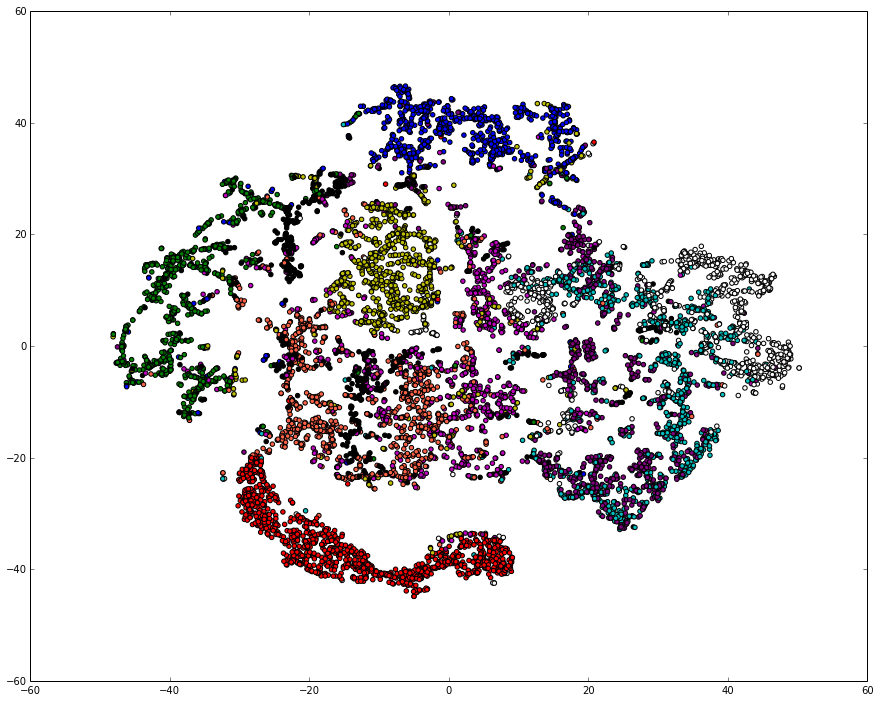

In [71]:
x = np.loadtxt('result.dat', delimiter = '\t')
print x.shape
plt.figure(figsize = (15, 12), dpi = 80)
plt.scatter(x[:, 0], x[:, 1], c = col_l)
plt.show()